Making some plots to tweet about the paper. Objectives: Overall SED, comparison with the Sun, the science plot.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import astropy.io.fits as fits
import os
from scipy.io.idl import readsav
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.modeling import models, fitting
from craftroom import resample
from scipy.interpolate import interp1d


%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
import mplcyberpunk
plt.style.use("cyberpunk")

In [5]:
m1data = Table.read('saved_models/trappist-1_model_const_res_v07.ecsv')
m1w, m1f =  m1data['WAVELENGTH'], m1data['FLUX']

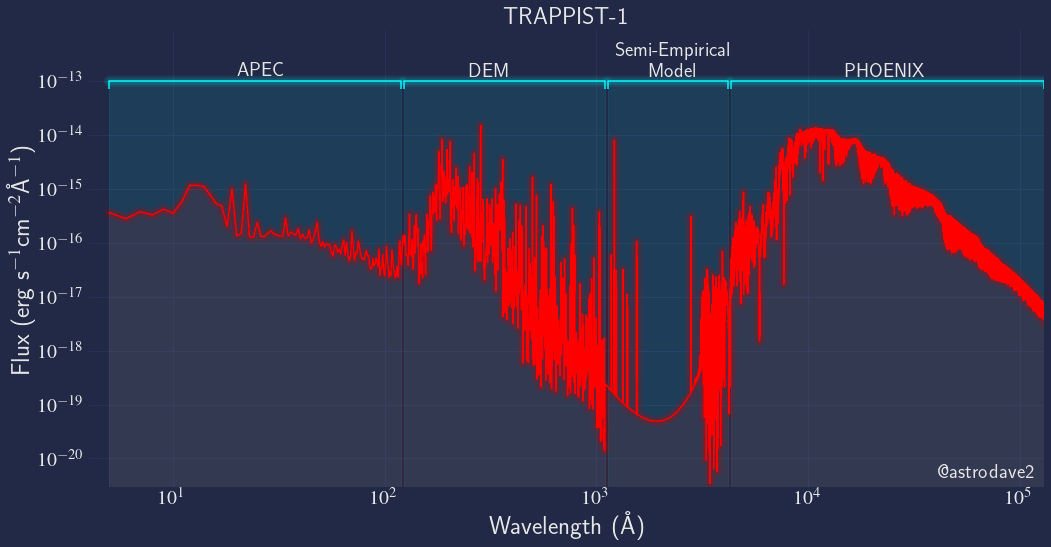

In [9]:
plt.figure(figsize=(15, 8))

plt.plot(m1w, m1f, c='C4')

labely = 1e-13
efac = 0.3
labelfac = 1.2
    
plt.errorbar((5,120),(labely, labely), yerr= [[efac*labely,efac*labely],[0,0]], c ='C0')
plt.annotate('APEC', (20, labelfac*labely))

plt.errorbar((123,1100),(labely, labely), yerr= [[efac*labely,efac*labely],[0,0]], c ='C0')
plt.annotate('DEM', (250, labelfac*labely))

plt.errorbar((1131, 4200),(labely, labely), yerr= [[efac*labely,efac*labely],[0,0]], c ='C0')
plt.annotate('Semi-Empirical\n Model', (2300, labelfac*labely), ha='center')

plt.errorbar((4301,  130000),(labely, labely), yerr= [[efac*labely,efac*labely],[0,0]], c ='C0')
plt.annotate('PHOENIX', (15000, labelfac*labely))


plt.xscale('log')
plt.yscale('log')
plt.xlim(4, 130001)
plt.ylim(3e-21, 9e-13)

plt.ylabel('Flux (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)', size=25)
plt.xlabel('Wavelength (\AA)', size=25)
mplcyberpunk.add_glow_effects()

plt.title('TRAPPIST-1')
plt.tight_layout()
plt.annotate('@astrodave2', (0.99, 0.01), xycoords='axes fraction', ha='right', va='bottom')
plt.savefig('../plots/t1cp_r.png', dpi=150)

In [23]:
sol_spec =  readsav('../../../stuff/Solar-data.idlsav')
w_sol, f_sol = sol_spec['wave']*10, sol_spec['flux']*100
w_sol, f_sol = w_sol[w_sol >= m1w[0]], f_sol[w_sol >= m1w[0]]
d_t1 = 12.1*u.pc 
d_sun = 1*u.au.to(u.pc)

#### scale by bolometric ps flux
r_t1 = 0.117*u.Rsun
#r_674 = 0.35*u.Rsun
t_t1= 2560*u.K
#t_674 = 3400*u.K
t_sun = 5777*u.k
bb_scale = ((u.Rsun**2 * t_sun**4)/(r_t1**2 * t_t1**4)*(d_t1/d_sun)**2).value

[0.018942461658199808, 0.023992418349443854, 0.04864997693231791, 0.05131643030421871]
[0.011534   0.01579    0.02226    0.02924    0.038774   0.04681528
 0.0618656 ]
[397.4213438424208, 339.6644507892247, 286.0741268596016, 249.60453803100563, 216.75586530522367, 197.26377890220812, 171.59970876979878]
[0.01487121 0.02024137 0.02914757 0.04554307 0.05948483]


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:147: UserWarning: AutoMinorLocator does not work with logarithmic scale
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:150: UserWarning: AutoMinorLocator does not work with logarithmic scale
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:150: UserWarning: AutoMinorLocator does not work with logarithmic scale
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: AutoMinorLocator does not work with logarithmic scale
  fig.canvas.print_figure(bytes_io, **kw)


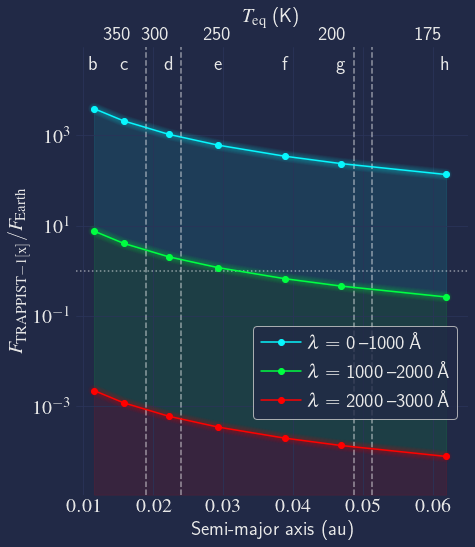

In [53]:
S_effsuns = [1.776,1.107,0.356,0.32]

a_all = [2.136e-4, 1.332e-4, 6.171e-5, 5.547e-5]
b_all = [2.533e-8, 1.58e-8, 1.698e-9, 1.526e-9]
c_all = [-1.332e-11, -8.308e-12,-3.198e-12,-2.874e-12]
d_all = [-3.097e-15,-1.931e-15,-5.575e-16,-5.011e-16]

t_star = t_t1.value - 5780 

l_t1 = 10**-3.28 #lsun

hzs = []
for s, a, b, c, d in zip(S_effsuns, a_all, b_all, c_all,d_all):
    Seff = s + a*t_star + b*t_star**2 + c*t_star**3 +d*t_star**4
    d_hz = (l_t1/Seff)**0.5
    hzs.append(d_hz)
print (hzs)

t1sw, t1sf = resample.bintogrid(m1w, m1f, newx=w_sol)


t1_a = np.array([11.534, 15.79, 22.26, 29.24, 38.7740, 46.81528, 61.8656])*1e-3 
t1_a_error_up = np.array([0.099, 0.14, 0.19, 0.25, 0.33, 0.40, 0.53])*1e-3
t1_a_error_down = np.array([0.092, 0.13, 0.18, 0.23, 0.31, 0.37, 0.49])*1e-13
teqs = [397.6, 339.7, 286.2, 249.7, 217.7, 197.3, 171.7]
names  = ['b', 'c', 'd', 'e', 'f','g', 'h']

xuv_cuts = [0, 1000, 2000, 3000]
fig, ax = plt.subplots(figsize=(7,8))


def make_teq(a):
    a = (a*u.au).to(u.m)
    lt1 = (0.000553*u.Lsun).to(u.W)
    Ab = 0
    teq = ( (lt1*(1-Ab)) / (16*const.sigma_sb*np.pi*a**2) )**(1/4)
    return teq

def make_a(teff):
    lt1 = (0.000553*u.Lsun).to(u.W)
    Ab = 0
    coeff = (( (lt1*(1-Ab)) / (16*const.sigma_sb*np.pi))**(1/4))
    a = (coeff/(teff*u.K))**2
    return a.to(u.au)
    
#make_a(300)
    
lt1 = (0.000553*u.Lsun).to(u.W)
Ab = 0
coeff = (( (lt1*(1-Ab)) / (16*const.sigma_sb*np.pi))**(1/4))
def t_to_s(x):
    a = (x*u.au).to(u.m)
    lt1 = (0.000553*u.Lsun).to(u.W)
    Ab = 0
    teq = ( (lt1*(1-Ab)) / (16*const.sigma_sb*np.pi*a**2) )**(1/4)
    return teq.value

    
d_t1_au = d_t1.to(u.au).value
print(t1_a)

print([make_teq(a).value for a in t1_a])

ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    top=False)      # ticks along the bottom edge are off   

cols = ['C0', 'C3', 'C4']



for i in range(len(xuv_cuts)-1):
    cut, cutu = xuv_cuts[i], xuv_cuts[i+1]
    #plt.subplot(2,1,i+1)
    mask = (w_sol >cut) & (w_sol <cutu)
    xuv_earth = np.trapz(f_sol[mask], w_sol[mask])
    xuv_t1 = np.trapz(t1sf[mask], t1sw[mask])
    planet_xuv = []
    xuv_eu = []
    xuv_el = []
    for p, eu, el in zip(t1_a, t1_a_error_up, t1_a_error_down):
        xuv = (xuv_t1/xuv_earth)*(d_t1_au/p)**2
        xuv_up = xuv*(eu/p)
        xuv_down = xuv*(el/p)
        planet_xuv.append(xuv)
        xuv_eu.append(xuv_up)
        xuv_el.append(xuv_down)

    #plt.errorbar(np.array(t1_a), np.array(planet_xuv), xerr=[t1_a_error_down, t1_a_error_up], 
          #      yerr=[np.array(xuv_el), np.array(xuv_eu)], marker='o', label = r'$\lambda = $ {0}\,--{1}\,\AA'.format(cut, cutu))
    plt.plot(np.array(t1_a), np.array(planet_xuv), marker='o', zorder=100, label = r'$\lambda = $ {0}\,--{1}\,\AA'.format(cut, cutu), c=cols[i])
    if i > 0:
        plt.fill_between(np.array(t1_a), xup, np.array(planet_xuv), color=cols[i-1], alpha=0.1, zorder=-10)
    if i == 2:
        plt.fill_between(np.array(t1_a), np.array(planet_xuv), 1.1e-5, color=cols[i], alpha=0.1, zorder=-10)       
    
    xup = np.array(planet_xuv)
    
#ax.plot([0, 1000], [1e-10,1e-10])

plt.legend(loc=(0.45, 0.17), frameon=True)

mplcyberpunk.make_lines_glow()

ax.set_ylabel('$F_{\mathrm{TRAPPIST-1 [x]}}/F_{\mathrm{Earth}}$')
    #if i ==0:
[plt.annotate(name, (p, 0.95), xycoords=('data', 'axes fraction'), ha='center') for name, p in zip(names, t1_a)]

[plt.axvline(hz, c='w', ls='--', alpha = 0.5) for hz in hzs]

   # plt.ylim(-0.9, 49)
ax.set_xlabel('Semi-major axis (au)')
ax.set_yscale('log')
ax.set_ylim(1.1e-5, 9e4)
ax.set_xlim(0.009, 0.065)
plt.axhline(1, ls=':',alpha = 0.5, c='w')


teffs = np.array([350, 300, 250, 200, 175])
tas = np.array([make_a(t).value for t in teffs])

teqs = np.array([make_teq(a).value for a in t1_a])

print(tas)

ax2 = ax.twiny()
ax2.tick_params(
    axis='x',          # changes apply to the x-axis
    which='minor',      # both major and minor ticks are affected
    top=False)      # ticks along the bottom edge are off   


teqp = np.array([str(t) for t in teffs])
ax2.set_xticks(tas, minor=False)
ax2.set_xticklabels(teqp)

ax2.set_xlim(0.009, 0.065)
ax2.set_xlabel(r'$T_{\mathrm{eq}}$ (K)', size=20)

ax2.grid(b=None)





plt.tight_layout()
#plt.subplots_adjust(top=0.7)

plt.savefig('../plots/t1_planets_xuv_teq_cp.png', dpi=150)

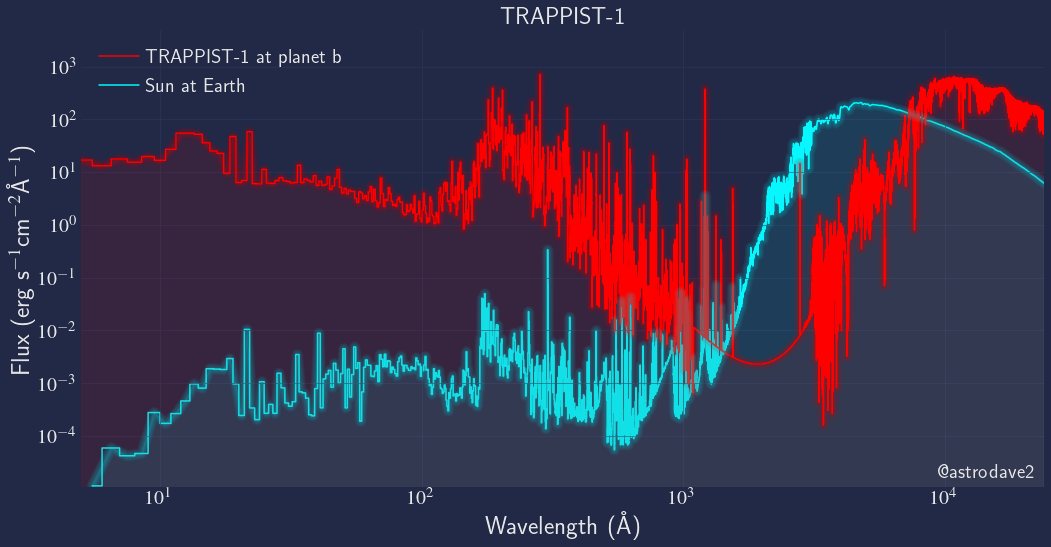

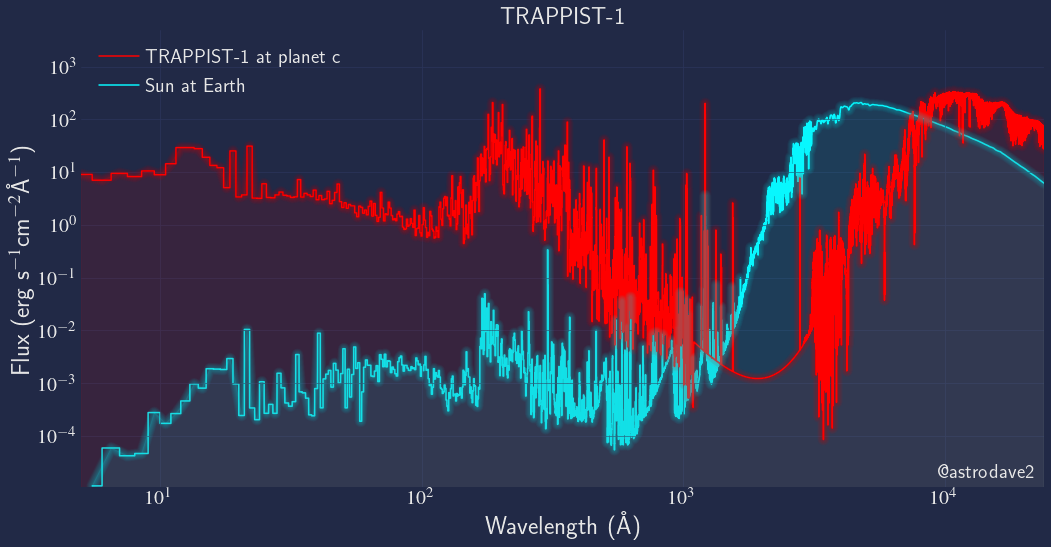

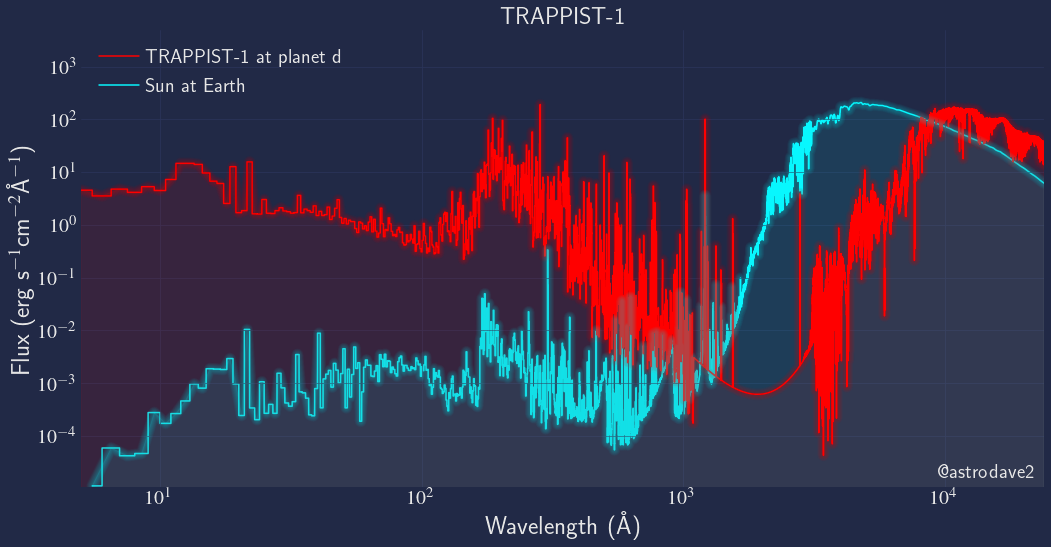

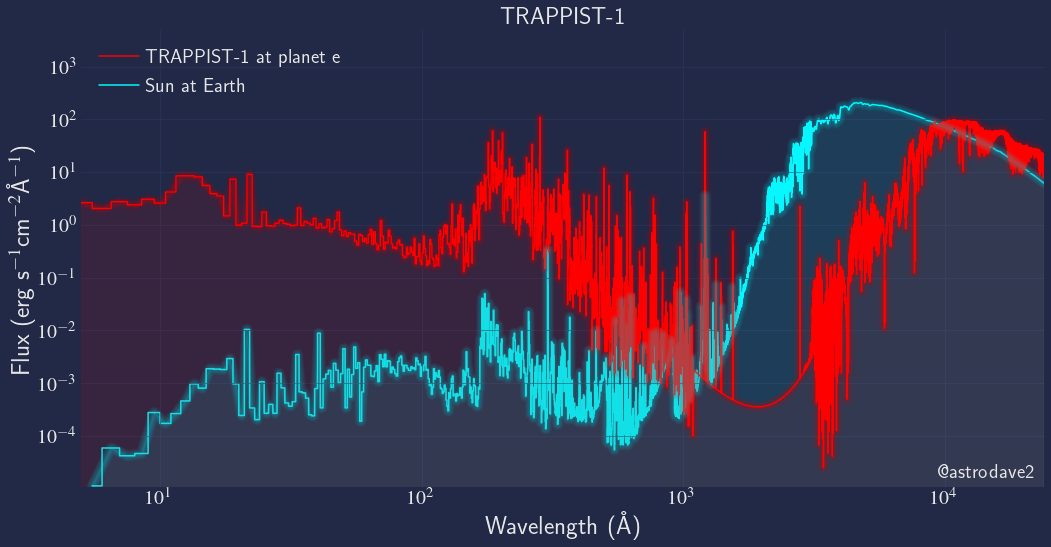

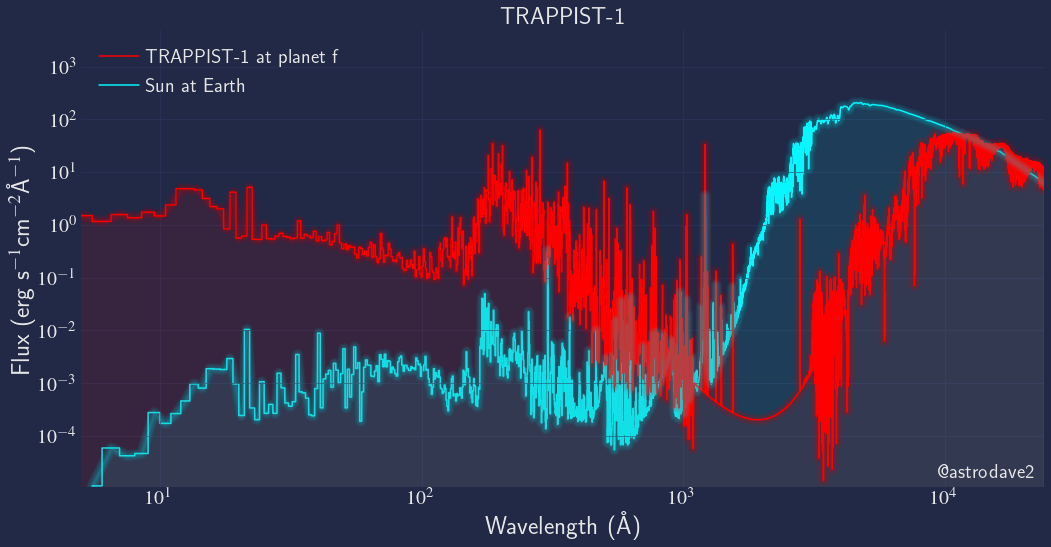

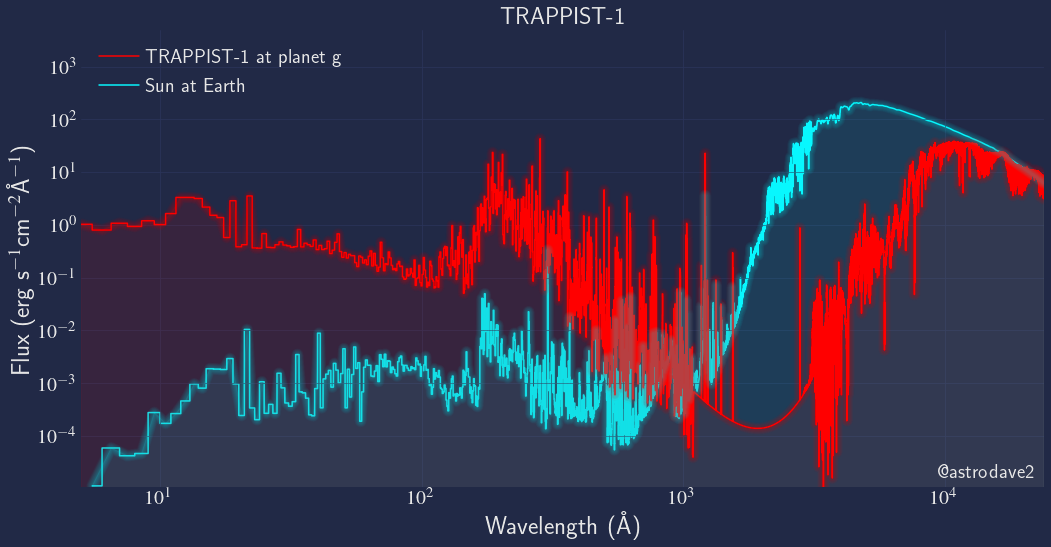

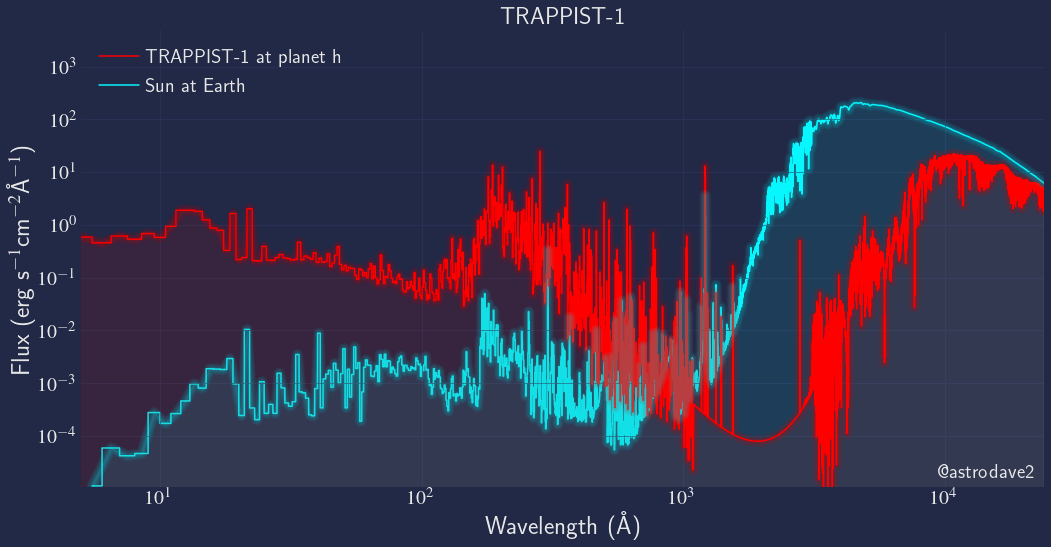

In [67]:
d_t1 = 12.1*u.pc 
t1scale = (d_t1.to(u.au)/a_t1e)**2


t1_a = np.array([11.534, 15.79, 22.26, 29.24, 38.7740, 46.81528, 61.8656])*1e-3
names  = ['b', 'c', 'd', 'e', 'f','g', 'h']

for name, a in zip(names, t1_a):

    t1scale = (d_t1.to(u.au)/a)**2

    plt.figure(figsize=(15, 8))


    plt.step(m1w[m1w <=w_sol[-1]], m1f[m1w <=w_sol[-1]]*t1scale, where='mid', c='C4', label = 'TRAPPIST-1 at planet {}'.format(name))
    plt.xscale('log')
    plt.yscale('log')
    plt.step(w_sol[w_sol>=m1w[0]], f_sol[w_sol>m1w[0]], zorder=-100, c='C0', label = 'Sun at Earth' , where='mid', alpha=1)
    plt.ylim(1.1e-5)
    plt.legend(loc=2)
    plt.xlim(m1w[0], w_sol[-1])





    plt.xscale('log')
    plt.yscale('log')
    #plt.xlim(4, 130001)
    plt.ylim(1.1e-5, 5e3)

    plt.ylabel('Flux (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)', size=25)
    plt.xlabel('Wavelength (\AA)', size=25)
    mplcyberpunk.add_glow_effects()

    plt.title('TRAPPIST-1')
    
    plt.annotate('@astrodave2', (0.99, 0.01), xycoords='axes fraction', ha='right', va='bottom')
    plt.tight_layout()
    plt.savefig('../plots/gif_plots/t1{}_v_sun_cp150.png'.format(name), dpi=150)
    plt.show()
    